In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("../data/raw")

PD_KW = dict(dtype_backend="pyarrow") 

In [3]:
def load_csv(path: Path, usecols=None, dtypes=None, nrows=None):
    """
    Carga un CSV a DataFrame de forma robusta.
    - usecols: columnas a leer (si quieres probar con un subconjunto).
    - dtypes: mapeo de tipos por columna si ya los conoces.
    - nrows: para muestrear primeras N filas si necesitas una carga rápida.
    """
    if not path.exists():
        raise FileNotFoundError(f"No existe: {path}")

    try:
        df = pd.read_csv(
            path,
            usecols=usecols,
            dtype=dtypes,
            low_memory=False,    # evita inferencias parciales
            on_bad_lines="warn", # avisa si hay líneas corruptas
            **PD_KW               # usa backend pyarrow si está disponible
        )
    except TypeError:
        df = pd.read_csv(
            path,
            usecols=usecols,
            dtype=dtypes,
            low_memory=False,
            on_bad_lines="warn",
        )
    return df


In [4]:
path_chess   = DATA_DIR / "chessData.csv"
path_random  = DATA_DIR / "random_evals.csv"
path_tactic  = DATA_DIR / "tactic_evals.csv"

df_chess  = load_csv(path_chess)
#df_random = load_csv(path_random)
#df_tactic = load_csv(path_tactic)

In [5]:
def overview(df: pd.DataFrame, name: str = "DataFrame", show_cols=20):
    print("=" * 100)
    print(f"📦 {name}")
    print("- Dimensiones:", df.shape)                 
    print("- Columnas:", len(df.columns))
    print("- Primeras columnas:", list(df.columns[:show_cols]))
    print("\n🔹 Tipos de datos:")
    display(df.dtypes.to_frame("dtype").head(show_cols))

    print("\n🔹 Memoria estimada por columna (Top 10):")
    mem = df.memory_usage(deep=True).sort_values(ascending=False).head(10)
    display((mem / (1024**2)).round(3).rename("MB").to_frame())

    print("\n🔹 df.info():")
    df.info(memory_usage="deep")

    print("\n🔹 df.head():")
    display(df.head(3))

    print("\n🔹 Valores únicos por columna (muestra):")
    display(df.nunique(dropna=True).sort_values(ascending=False).head(10).to_frame("nunique"))

    # (complemento mínimo para Paso 4, solo conteo bruto de nulos)
    print("\n🔹 Conteo de nulos (Top 10):")
    display(df.isna().sum().sort_values(ascending=False).head(10).to_frame("nulos"))


In [6]:
#overview(df_random, "random_evals.csv")
#overview(df_tactic, "tactic_evals.csv")
overview(df_chess,  "chessData.csv")

📦 chessData.csv
- Dimensiones: (12958035, 2)
- Columnas: 2
- Primeras columnas: ['FEN', 'Evaluation']

🔹 Tipos de datos:


,dtype
FEN,string[pyarrow]
Evaluation,string[pyarrow]



🔹 Memoria estimada por columna (Top 10):


,MB
FEN,741.373
Evaluation,90.911
Index,0.000



🔹 df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 2 columns):
 #   Column      Dtype          
---  ------      -----          
 0   FEN         string[pyarrow]
 1   Evaluation  string[pyarrow]
dtypes: string[pyarrow](2)
memory usage: 832.3 MB

🔹 df.head():


,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9



🔹 Valores únicos por columna (muestra):


,nunique
FEN,12954834
Evaluation,13544



🔹 Conteo de nulos (Top 10):


,nulos
FEN,0
Evaluation,0


# 3. Estadísticas univariadas categóricas

In [7]:
def get_categorical_columns(df: pd.DataFrame, max_card_as_cat: int = 200):
    """
    Devuelve columnas categóricas (object/string/category/bool) + numéricas discretas con poca cardinalidad.
    - max_card_as_cat: si una numérica tiene <= ese número de únicos, la tratamos como categórica (discreta).
    """
    # dtypes categóricos obvios
    cat_like = df.select_dtypes(include=["object", "string", "category", "bool"]).columns.tolist()

    # numéricas con baja cardinalidad (ej. 0/1, 1..10, etc.)
    numeric_low_card = []
    for c in df.select_dtypes(include=[np.number]).columns:
        nunq = df[c].nunique(dropna=True)
        if nunq <= max_card_as_cat:
            numeric_low_card.append(c)

    # combinación única preservando orden
    seen, result = set(), []
    for c in cat_like + numeric_low_card:
        if c not in seen:
            seen.add(c)
            result.append(c)
    return result


In [8]:
def summarize_categoricals(df: pd.DataFrame, cols=None, topn_mode: int = 1):
    """
    Retorna un DataFrame con:
    - dtype
    - n_unique y %_unique
    - n_missing y %_missing
    - mode (moda) y su frecuencia relativa
    """
    if cols is None:
        cols = get_categorical_columns(df)

    rows = []
    n = len(df)
    for c in cols:
        ser = df[c]
        nunq = ser.nunique(dropna=True)
        nmiss = ser.isna().sum()
        vc = ser.value_counts(dropna=True)
        if len(vc) > 0:
            moda = ", ".join([f"{idx}" for idx in vc.index[:topn_mode]])
            moda_freq = float((vc.iloc[0] / (n - nmiss)).round(4))
        else:
            moda, moda_freq = None, np.nan

        rows.append({
            "col": c,
            "dtype": str(ser.dtype),
            "n_unique": nunq,
            "%_unique": round(100 * nunq / max(1, n - nmiss), 2),
            "n_missing": int(nmiss),
            "%_missing": round(100 * nmiss / n, 2),
            "mode": moda,
            "mode_freq": moda_freq,
        })
    out = pd.DataFrame(rows).set_index("col").sort_values(["%_missing","%_unique"], ascending=[False, False])
    return out

In [9]:
def analyze_categorical(
    df: pd.DataFrame, 
    col: str, 
    target: str | None = None,
    top_k: int = 20, 
    min_freq_plot: int = 1
):
    """
    - Tabla de frecuencias absolutas y relativas
    - Barras Top-K
    - (Opcional) Resumen del target por categoría (count, mean, median, std)
    """
    ser = df[col]
    n = len(ser)
    vc = ser.value_counts(dropna=False)
    vc_nonan = ser.value_counts(dropna=True)

    # Tabla de frecuencias
    freq_tbl = pd.DataFrame({
        "count": vc_nonan,
        "pct": (vc_nonan / vc_nonan.sum() * 100).round(2)
    })
    display(freq_tbl.head(top_k))

    # Barras (Top-K) – evita ruido de la larga cola
    vc_plot = vc_nonan[vc_nonan >= min_freq_plot].head(top_k)
    plt.figure(figsize=(9, 4))
    vc_plot.sort_values(ascending=True).plot(kind="barh")
    plt.title(f"{col} – Top {len(vc_plot)} categorías")
    plt.xlabel("frecuencia")
    plt.tight_layout()
    plt.show()

    # (Opcional) Relación con target numérico
    if target is not None and target in df.columns and np.issubdtype(df[target].dtype, np.number):
        # Tomar solo las Top-K categorías para que sea legible
        topcats = vc_nonan.index[:top_k]
        tmp = df[df[col].isin(topcats)][[col, target]].dropna()
        grp = tmp.groupby(col)[target].agg(["count","mean","median","std"]).sort_values("count", ascending=False)
        display(grp)

        # Boxplot del target por categoría (Top-K)
        if len(topcats) >= 2:
            plt.figure(figsize=(10, 4))
            tmp = tmp.copy()
            tmp[col] = tmp[col].astype("category")
            tmp[col] = tmp[col].cat.reorder_categories(list(topcats), ordered=True)
            tmp.boxplot(column=target, by=col, rot=45)
            plt.suptitle("")
            plt.title(f"{target} por {col} (Top {len(topcats)})")
            plt.tight_layout()
            plt.show()


,dtype,n_unique,%_unique,n_missing,%_missing,mode,mode_freq
col,,,,,,,
FEN,string[pyarrow],12954834,99.98,0,0.0,r2qkbnr/pp3ppp/2bpp3/8/3QP3/2N2N2/PPP2PPP/R1B2...,0.0000
Evaluation,string[pyarrow],13544,0.10,0,0.0,0,0.0973


🔹 Evaluation


,count,pct
Evaluation,,
0,1261356,9.73
+13,157897,1.22
-13,148689,1.15
+46,41674,0.32
+53,41404,0.32
+61,40257,0.31
+38,39831,0.31
+69,39133,0.3
+30,38798,0.3


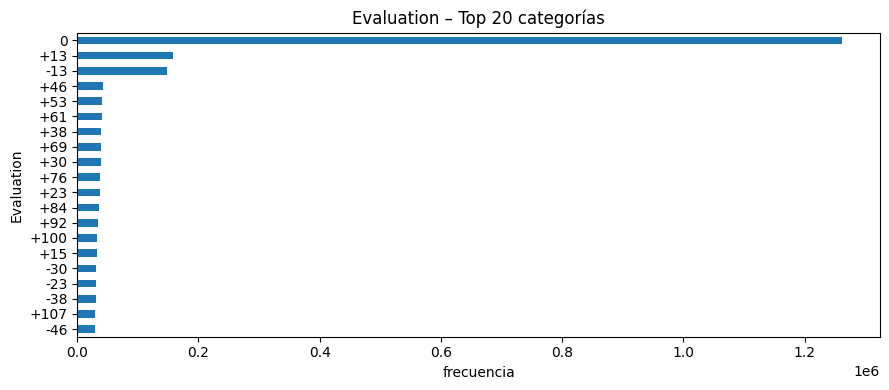

In [10]:
# Detectar categóricas (y filtrar altísima cardinalidad, p.ej. FEN)
cat_cols = get_categorical_columns(df_chess, max_card_as_cat=100)  # ajusta si lo requieres
summary = summarize_categoricals(df_chess, cols=cat_cols)
display(summary.head(30))

# Heurística para excluir columnas "ID-like" (casi todos únicos) o cardinalidad muy alta
mask_keep = (summary["%_unique"] <= 50)  # quedarnos con columnas con <=50% de únicos
cols_to_plot = summary[mask_keep].index.tolist()

# (Si tienes un target numérico, pásalo acá; si no, deja None)
TARGET_COL = None  # por ejemplo "eval" o "score" cuando lo definas

for c in cols_to_plot:
    print("="*100)
    print(f"🔹 {c}")
    analyze_categorical(df_chess, c, target=TARGET_COL, top_k=20, min_freq_plot=2)
